# コメントをやる

やること：帰無仮説が正しいのに棄却してしまう確立が5パーセントかを調べる

なのでまずは純粋戦略ナッシュ均衡のデータを作る

## まず純粋戦略の仮定の下ではbrが正しく係数を推定できているかを見る。


結論：できてない

→原因はｄーえたの出し方が間違ってたこと。summarynoteでも修正しておきましょう（乱数のところも含めて）

カットしない方がrobustもいい推定できる

In [10]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

initial = [0.8,-0.5,-0.25]
s = st.norm()
e = st.norm()
times = 10
M = 1000
T = 100
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25
cut = 0.5
tole = 0.000005
maxx = 100000
hausman_result = np.ones(times)

def nash2(x, mu1, mu2, true_delta):
    if x[0] < -mu1:
        if x[1] < -mu2:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -mu1 < x[0] < -mu1 -true_delta:
        if x[1] < -mu2:
            return [1,0,2]
        elif -mu2 < x[1] < -mu2 -true_delta:
            return [1,0,2]
        else:
            return [0,1,1]
    else:
        if x[1] < -mu2 -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

def diffe(p, d):
    p_0 = sum([True for i in d[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in d[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p, d):
    num0 = sum([True for i in d[p, :, 2] if i == 0.0])
    num2 = sum([True for i in d[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)

def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

def hausman(result1, result2):
    H_br = nd.Hessian(br)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(br1)(result1)
    circle_1 = np.dot(J_br.T, J_br)

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)

    circle_6 = robust(result2)

    # ここら辺のMの処理を確認
    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [11]:
delta_result = np.ones((2, times))

for time in range(times):
    data = e.rvs(size = (M,3), random_state = time)
    eps = s.rvs(size = (M,T,2), random_state = time+100)
    data2 = np.ones((M,T,3))
    for m in range(M):
        for t in range(T):
            data2[m, t, :] = nash2(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, data[m, 0]*beta1 + data[m, 2]*beta2 ,delta)
    d = np.array([diffe(p, data2) for p in range(M)])
    d2 = np.reshape(np.array([num(p, data2) for p in range(M)]), (M, 3))
    df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
    #df = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > cut) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > cut)]
    pop = df[["Pop"]].values[:, 0]
    dist1 = df[["Dist1"]].values[:, 0]
    dist2 = df[["Dist2"]].values[:, 0]
    num0 = df[["num0"]].values[:, 0]
    num2 = df[["num2"]].values[:, 0]
    diff = df[["diff"]].values[:, 0]
    
    result_br = NR(initial, br, tole, maxx)
    result_rob = NR(initial, robust, tole, maxx)
    
    delta_result[0, time] = result_br[2]
    delta_result[1, time] = result_rob[2]
    
    #h, rank = hausman(result_br, result_rob)
    
    #hausman_result[time] = h[0, 0]

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


(array([ 2.,  0.,  0.,  2.,  0.,  1.,  2.,  1.,  1.,  1.]),
 array([-0.29927991, -0.28968201, -0.28008412, -0.27048622, -0.26088832,
        -0.25129042, -0.24169252, -0.23209462, -0.22249673, -0.21289883,
        -0.20330093]),
 <a list of 10 Patch objects>)

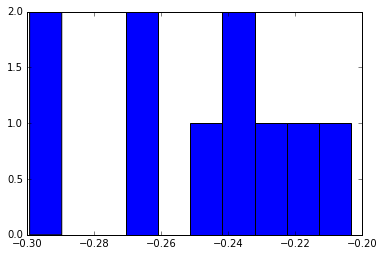

In [12]:
#データの出し方が間違ってたね。
plt.hist(delta_result[0, :], bins = 10)

(array([ 1.,  0.,  1.,  1.,  2.,  1.,  2.,  0.,  0.,  2.]),
 array([-0.41799545, -0.39177167, -0.3655479 , -0.33932413, -0.31310035,
        -0.28687658, -0.26065281, -0.23442904, -0.20820526, -0.18198149,
        -0.15575772]),
 <a list of 10 Patch objects>)

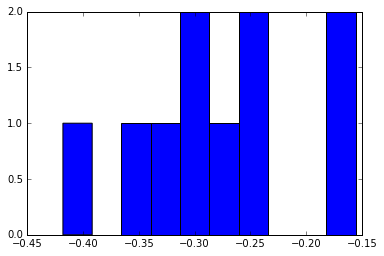

In [13]:
plt.hist(delta_result[1, :], bins = 10)